# Convolutional Neural Networks

So far we've looked at feed-forward neural nets, which are designed for inputs of constant size, as well as recurrent networks, which are designed for sequences of data. In this chapter we will take a look at convolutional neural networks (CNNs).

## Motivation
The most popular application of CNNs is the processing of $2$-dimensional data, or more specifically images. We will motivate the use of CNNs by looking at an example from the MNIST dataset, which is used for handwritten digit recognition:

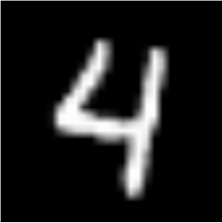

Suppose we would like to recognize which digit is written in this picture. If we assume that all our images have the same dimensions, say $10 \times 10$ pixels, we could take the raw pixel values and feed them into a feed-forward net with $10 * 10 = 100$ input neurons. The picture above, scaled down and converted to grayscale, would look like this:

\begin{equation*}
    \begin{pmatrix}
         0 &   0 &   0 &   0 &   0 &   0 &   0 &   0 &   0 &   0\\
         0 &   0 &   0 &   0 &  31 &   0 &   0 &   0 &   0 &   0\\
         0 &   0 &   0 &  18 & 158 &   0 &  74 &  68 &   0 &   0\\
         0 &   0 &   0 & 100 & 113 &   0 & 118 &  62 &   0 &   0\\
         0 &   0 &  41 & 184 &  14 &   0 & 145 &  22 &   0 &   0\\
         0 &   0 & 110 & 231 & 180 & 139 & 196 &  15 &   0 &   0\\
         0 &   0 &   4 &  29 &  63 &  96 & 161 &   5 &   0 &   0\\
         0 &   0 &   0 &   0 &   0 &  61 & 145 &   2 &   0 &   0\\
         0 &   0 &   0 &   0 &   0 &  50 &  83 &   0 &   0 &   0\\
         0 &   0 &   0 &   0 &   0 &   0 &   0 &   0 &   0 &   0\\
    \end{pmatrix}
\end{equation*}

Even for humans it is still quite easy to guess the number from this low-resolution matrix representation. And in fact feed-forward networks do perform well on this task. However, the architecture is not ideal: Consider a case where the $4$ is drawn identically, but only slightly shifted to the left. In that case we might end up with a matrix like this:

\begin{equation*}
    \begin{pmatrix}
         0 &   0 &   0 &   0 &   0 &   0 &   0 &   0 &   0 &   0\\
         0 &   0 &  31 &   0 &   0 &   0 &   0 &   0 &   0 &   0\\
         0 &  18 & 158 &   0 &  74 &  68 &   0 &   0 &   0 &   0\\
         0 & 100 & 113 &   0 & 118 &  62 &   0 &   0 &   0 &   0\\
         41 & 184 &  14 &   0 & 145 &  22 &   0 &   0 &   0 &   0\\
         110 & 231 & 180 & 139 & 196 &  15 &   0 &   0 &   0 &   0\\
         4 &  29 &  63 &  96 & 161 &   5 &   0 &   0 &   0 &   0\\
         0 &   0 &   0 &  61 & 145 &   2 &   0 &   0 &   0 &   0\\
         0 &   0 &   0 &  50 &  83 &   0 &   0 &   0 &   0 &   0\\
         0 &   0 &   0 &   0 &   0 &   0 &   0 &   0 &   0 &   0\\
    \end{pmatrix}
\end{equation*}

We can still see mostly the same values in the matrix, even in the same arrangement. However, if we were to feed this matrix into our feed-forward net, the same values from before would end up at different input neurons and hence different weights. This means that the model would need to learn to detect the same shape at every possible position to reliably find the corresponding digit. It would be much better to have a shared set of weights that is applied to all parts of the image, right? This is where CNNs come into play.

## Convolutional Layers
The main idea of CNNs is to have a _sliding window_, i.e. a weight matrix smaller than the original input, which is applied to multiple regions of the image. To demonstrate this, let's look at the following $5 \times 5$ input matrix:

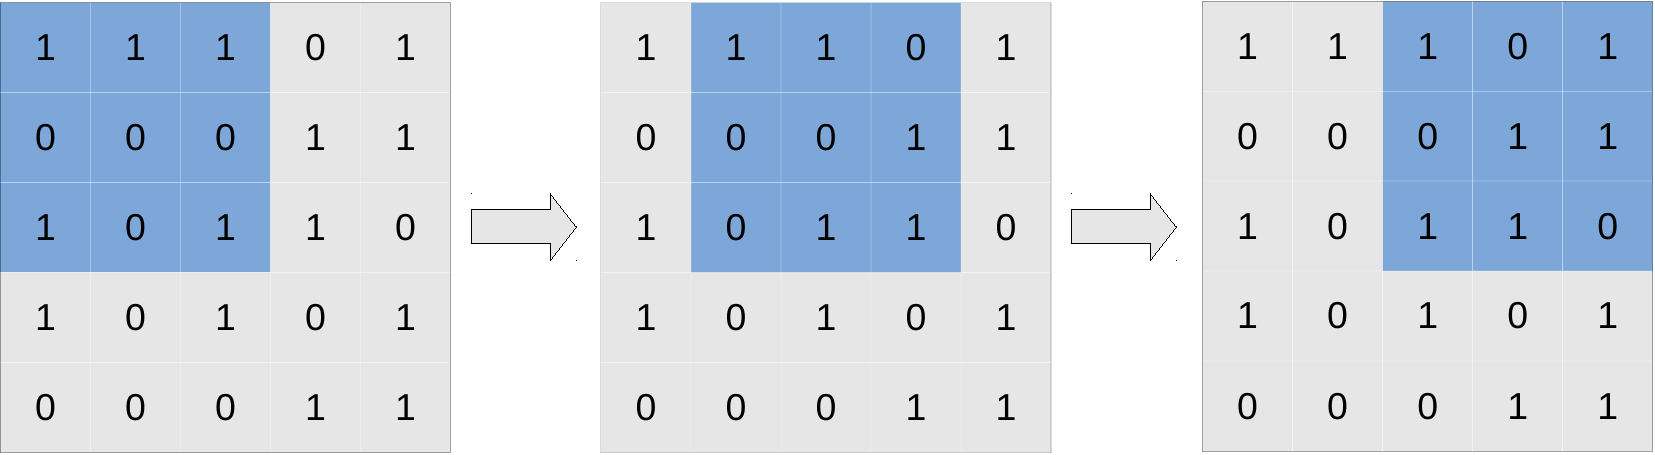

We slide the window across the original matrix by moving the window to the left and down. The number of fields we move the window (in this case just $1$) is called _stride_ and is a hyperparameter of the model. This method yields a total of $9$ $3 \times 3$ sub-matrices in this case. To these matrices we will now apply what's called a _filter_ or _kernel_, which is a trainable matrix (i.e. a parameter of the model) of the same size. Let's use a simple example filter

\begin{equation*}
    F =
    \begin{pmatrix}
        1 &   0 &   0 \\
        0 &   1 &   0 \\
        0 &   0 &   1 \\
    \end{pmatrix}.
\end{equation*}

In order to apply a filter we take each of the sub-matrices and weight them using the filter, i.e. we compute the element-wise product of the two matrices. For example, applying $F$ to the first sub-matrix in the figure above yields

\begin{equation*}
    \begin{pmatrix}
        1 &   1 &   1 \\
        0 &   0 &   0 \\
        1 &   0 &   1 \\
    \end{pmatrix}
    \odot
    \begin{pmatrix}
        1 &   0 &   0 \\
        0 &   1 &   0 \\
        0 &   0 &   1 \\
    \end{pmatrix}
    =
    \begin{pmatrix}
        1 &   0 &   0 \\
        0 &   0 &   0 \\
        0 &   0 &   1 \\
    \end{pmatrix}.
\end{equation*}

Finally we sum up all elements of the resulting matrix. In the example above the final sum is $2$. After doing this for all sub-matrices, we end up with $9$ numbers that we arrange in yet another matrix. This matrix is then the output of our convolution layer. In our case we end up with

\begin{equation*}
    \begin{pmatrix}
        2 &   2 &   2 \\
        1 &   1 &   2 \\
        1 &   2 &   2 \\
    \end{pmatrix}.
\end{equation*}

Note that the resulting matrix is smaller than the original input ($3 \times 3$ vs. $5 \times 5$). For this reason the result is often padded with zeros to retain the original dimensions, i.e.

\begin{equation*}
    \begin{pmatrix}
        0 &   0 &   0 &   0 &   0 \\
        0 &   2 &   2 &   2 &   0 \\
        0 &   1 &   1 &   2 &   0 \\
        0 &   1 &   2 &   2 &   0 \\
        0 &   0 &   0 &   0 &   0 \\
    \end{pmatrix}.
\end{equation*}

In practice, when dealing with images, there are some small differences in the approach:
* Images usually have three color channels, i.e. are represented by $3$-dimensional matrices. In that case we simply use filters that are $3$-dimensional as well.
* It is common to use a large number of filters instead of just one. As a result, the convolutional layer outputs multiple matrices. The idea is that each individual filter should learn its own low-level feature. In our example of digit recognition, we expect one filter to learn to output high numbers when it slides over a horizontal line, another one for vertical lines and so on. Then, in the subsequent layers, the model should be able to learn how to combine these low-level features to high-level features, e.g. detecting certain larger shapes or numbers.

## Pooling Layers
After we have now learned about convolutional layers, we need to look at _pooling layers_, which is the second common type of layers in CNNs.

Going back to the digit recognition example, say our input matrices are $10 \times 10 \times 3$ (three channels for RGB) and we apply $32$ filters to them. That leaves us with a total of $10 * 10 * 32 = 3200$ items in the matrices resulting from the convolutional layer. In order to classify an input image as a digit, usually a dense (fully-connected) layer with a softmax activation is used to squash the results into a low-dimensional vector ($10$ dimensions in our case). However, as we've seen earlier, even for tiny images like in our example the number of outputs can get very big. Pooling layers are meant to reduce the dimensionality while retaining the important features learned by the filters.

Pooling utilizes the same sliding window technique as before. Let's take your example matrix from before:

\begin{equation*}
    \begin{pmatrix}
        0 &   0 &   0 &   0 &   0 \\
        0 &   2 &   2 &   2 &   0 \\
        0 &   1 &   1 &   2 &   0 \\
        0 &   1 &   2 &   2 &   0 \\
        0 &   0 &   0 &   0 &   0 \\
    \end{pmatrix}
\end{equation*}

We again use a $3 \times 3$ sliding window, but this time we choose a stride of $2$. This gives us the following sub-matrices:

\begin{equation*}
    \begin{pmatrix}
        0 &   0 &   0 \\
        0 &   2 &   2 \\
        0 &   1 &   1 \\
    \end{pmatrix}
    \quad
    \begin{pmatrix}
        0 &   0 &   0 \\
        2 &   2 &   0 \\
        1 &   2 &   0 \\
    \end{pmatrix}
    \quad
    \begin{pmatrix}
        0 &   1 &   1 \\
        0 &   1 &   2 \\
        0 &   0 &   0 \\
    \end{pmatrix}
    \quad
    \begin{pmatrix}
        1 &   2 &   0 \\
        2 &   2 &   0 \\
        0 &   0 &   0 \\
    \end{pmatrix}
\end{equation*}

We now reduce each of these matrices to a single number by either taking the maximum (_max pooling_) or the average (_average pooling_). The result is a $2 \times 2$ matrix. For example, in the case of max pooling we get

\begin{equation*}
    \begin{pmatrix}
        2 &   2 \\
        2 &   2 \\
    \end{pmatrix}.
\end{equation*}

Note that, as before, this is not limited to the $2$-dimensional case but can easily be extended to higher dimensional data.

## Implementation
In this section we will train a small CNN on the MNIST dataset to do character recognition. [The code is taken from the Keras repository.](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py)

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


We first set some hyperparameters:

In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

The MNIST data can be directly loaded from keras. It is already split into training and test set.

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

We now have to reshape the data according to some keras setting (`channels_first` or `channels_last`). This setting determines what data shape the `Conv2D` layers expect. Note that this is still necessary even though our images have only one color channel.

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

The next step is normalizing the image data from $[0; 255]$ to $[0; 1]$. Normalized data usually gives better results than data with arbitrarily large numbers.

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Finally we have to convert our class labels to one-hot vectors as our model outputs a probability distribution (using softmax) and the labels are given as simple numbers.

In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Our model architecture consists of two convolutional layers with $32$ and $64$ $3 \times 3$ filters respectively. We then apply max pooling and dropout and finally two dense layers, the last of which uses the softmax activation to output our class probabilities. We use cross entropy loss and the AdaDelta optimizer.

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Training and evaluating the model yields the final results:

In [8]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 79s 1ms/step - loss: 0.2604 - acc: 0.9192 - val_loss: 0.0583 - val_acc: 0.9823
Epoch 2/12
60000/60000 [==============================] - 84s 1ms/step - loss: 0.0867 - acc: 0.9748 - val_loss: 0.0422 - val_acc: 0.9854
Epoch 3/12
60000/60000 [==============================] - 79s 1ms/step - loss: 0.0647 - acc: 0.9806 - val_loss: 0.0329 - val_acc: 0.9891
Epoch 4/12
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0523 - acc: 0.9846 - val_loss: 0.0327 - val_acc: 0.9895
Epoch 5/12
60000/60000 [==============================] - 83s 1ms/step - loss: 0.0470 - acc: 0.9858 - val_loss: 0.0282 - val_acc: 0.9900
Epoch 6/12
60000/60000 [==============================] - 83s 1ms/step - loss: 0.0411 - acc: 0.9874 - val_loss: 0.0298 - val_acc: 0.9901
Epoch 7/12
60000/60000 [==============================] - 82s 1ms/step - loss: 0